In [285]:
import os
import copy
import random
import struct
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats
from typing import Tuple
from datetime import datetime
from skimage.io import imread
from skimage.transform import resize
from scipy.stats import ttest_rel
from CloudNet.model import create_model
from CloudNet.metrics import overall_accuracy, precision, recall, jacc_coef

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_virtual_device_configuration(gpu, [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7.5 * 1024)])

# Load model and weights

In [6]:
model = create_model((384, 384), 4, 64)

In [7]:
# Already consider that multiple model weights will be available for the same architecture
MODEL_WEIGHTS = [
    '.checkpoints/weights.hdf5'
]

# Load the testing images

In [85]:
path = '/home/kevin/Downloads/CloudNetDataset'
file_list = 'training_patches_cleaned.csv'


with open(os.path.join(path, file_list), 'r') as f:
    content = [x.strip() for x in f.readlines()[1:]]

random.shuffle(content)
content = content[:1000]

files = []

for file in tqdm(content, desc="Loading Images", unit="file"):
    image = imread(os.path.join(path, f'Combined/Image/{file}.tif'))
    mask = imread(os.path.join(path, f"Combined/Mask/{file}.tif"))

    image = (image / 255).astype(np.float32)
    mask = (mask / 255).astype(np.float32)
    
    files.append([image, mask])

Loading Images: 100%|███████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.16file/s]


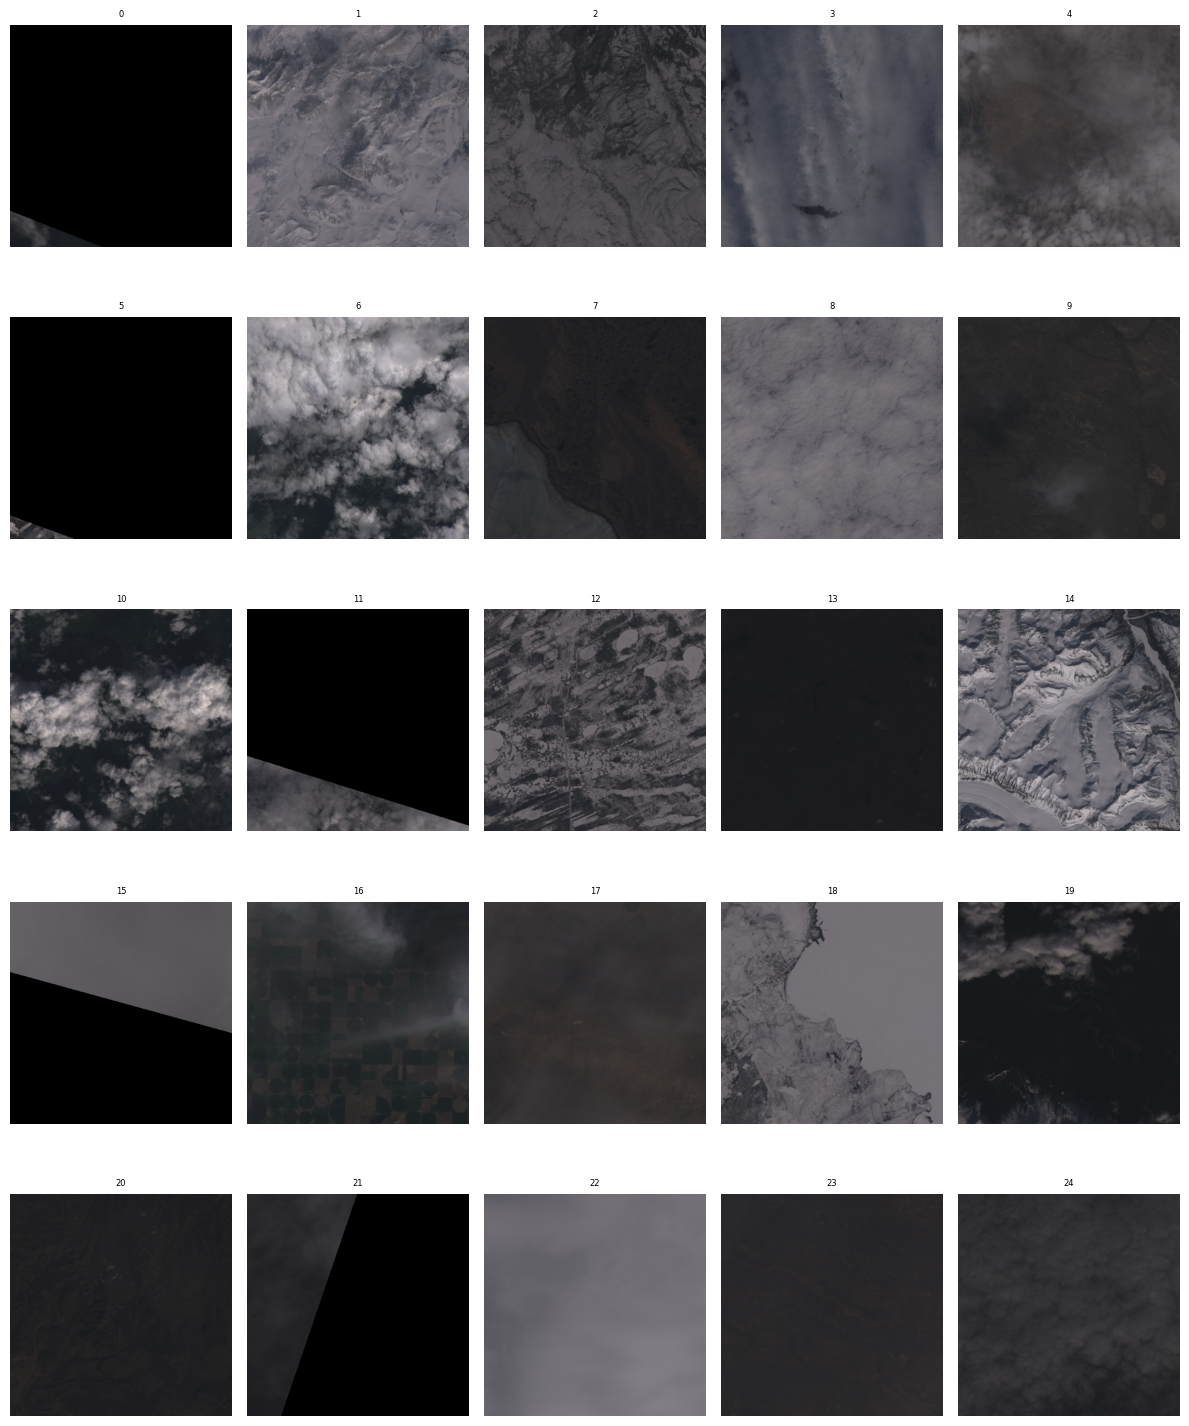

In [333]:
fig, axs = plt.subplots(5, 5, figsize=(12, 15))

axs = axs.flatten()

for i, image in enumerate(files[:25]):
    axs[i].imshow(image[0][:, :, :3])
    axs[i].set_title(i, fontsize=6)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

# Baseline model test

- Accuracy
- Output some images

In [28]:
model_accuracies = []
model_precisions = []
model_recalls = []

for weights in MODEL_WEIGHTS:
    print(f"[I] Start with model {weights}")
    model.load_weights(weights)
    accuracies = []
    precisions = []
    recalls = []
    for file, mask in files:
        img = file.astype(np.float32)
        img = img.reshape((1, 384, 384, 4))
        prediction = model.predict(img)
        accuracies.append(overall_accuracy(mask, prediction[0, :, :, 0]))
        precisions.append(precision(mask, prediction[0, :, :, 0]))
        recalls.append(recall(mask, prediction[0, :, :, 0]))
        
    model_accuracies.append(np.mean(accuracies))
    model_precisions.append(np.mean(precisions))
    model_recalls.append(np.mean(recalls))

[I] Start with model .checkpoints/weights.hdf5


2024-01-12 16:57:42.505486: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700


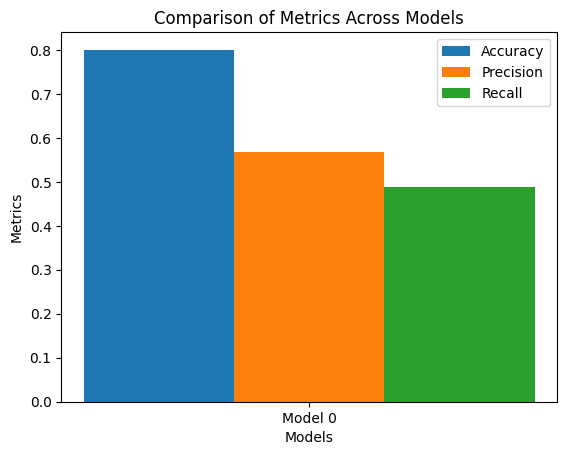

In [29]:
bar_width = 0.25

x_accuracy = np.arange(len(MODEL_WEIGHTS))
x_precision = [x + bar_width for x in x_accuracy]
x_recall = [x + bar_width for x in x_precision]

fig, ax = plt.subplots()
ax.bar(x_accuracy, model_accuracies, width=bar_width, label='Accuracy')
ax.bar(x_precision, model_precisions, width=bar_width, label='Precision')
ax.bar(x_recall, model_recalls, width=bar_width, label='Recall')

ax.set_xlabel('Models')
ax.set_ylabel('Metrics')
ax.set_title('Comparison of Metrics Across Models')
ax.set_xticks([x + bar_width for x in range(len(MODEL_WEIGHTS))])
ax.set_xticklabels([f'Model {i}' for i in range(len(MODEL_WEIGHTS))])
plt.legend()
plt.show()

## Exemplary output

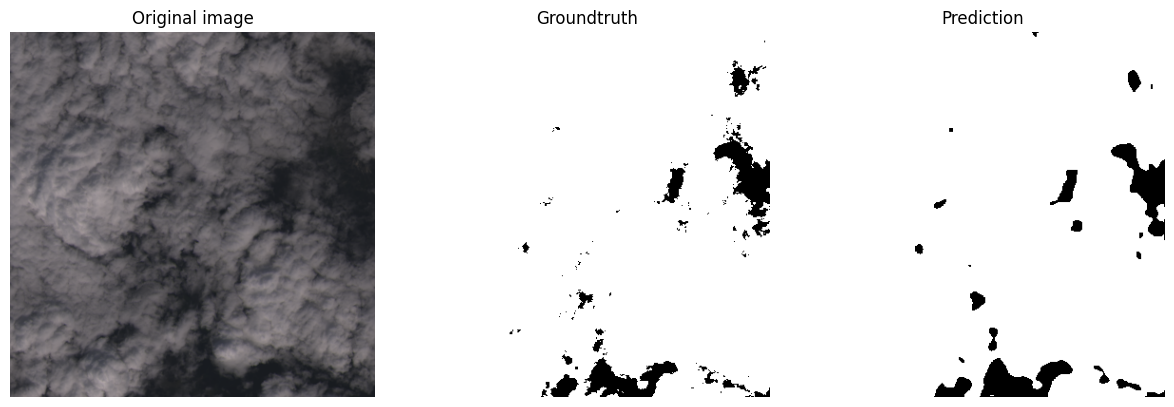

In [156]:
model.load_weights(MODEL_WEIGHTS[0])
img_idx = 584

img = files[img_idx][0].astype(np.float32)
img = img.reshape((1, 384, 384, 4))
prediction = model.predict(img)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(files[img_idx][0][:, :, :3])  # Change the colormap as needed
axes[0].set_title('Original image')
axes[0].axis('off')

axes[1].imshow(files[img_idx][1], cmap='gray')  # Change the colormap as needed
axes[1].set_title('Groundtruth')
axes[1].axis('off')

axes[2].imshow(np.where(prediction[0] < 0.5, 0, 1), cmap='gray')
axes[2].set_title('Prediction')
axes[2].axis('off')

plt.tight_layout()

plt.show()

# Apply filters to the images
- Use different image disturbances from Kornia
- Inject different radiation induced errors
- Apply dark current noise

# Inject bitflips into Model Weights

- Randomly select weights of the model and inject bit-flips
- Do a layer by layer injection of bit-flips into the network
- Inject different amount of bit-flips

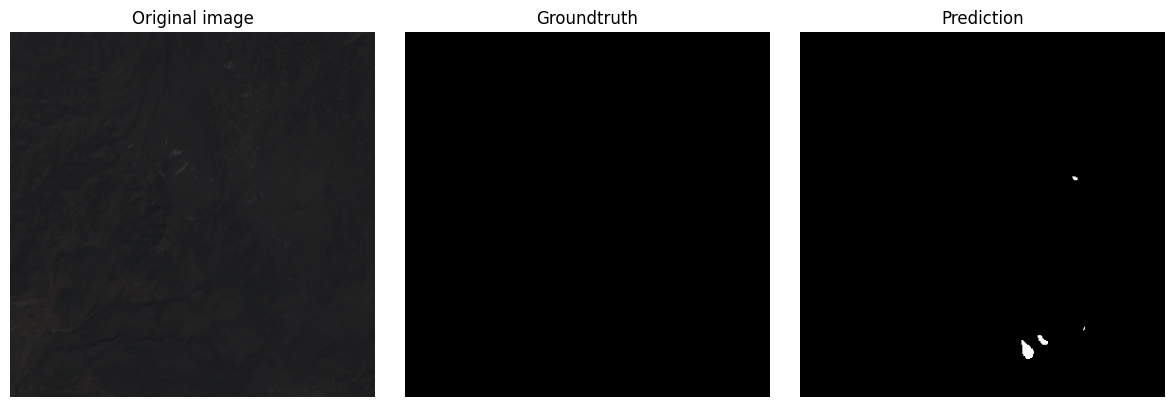

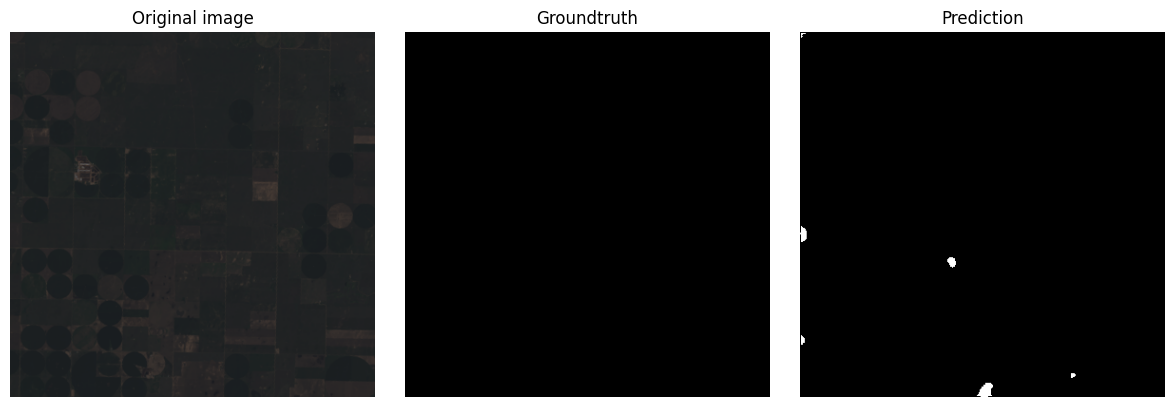

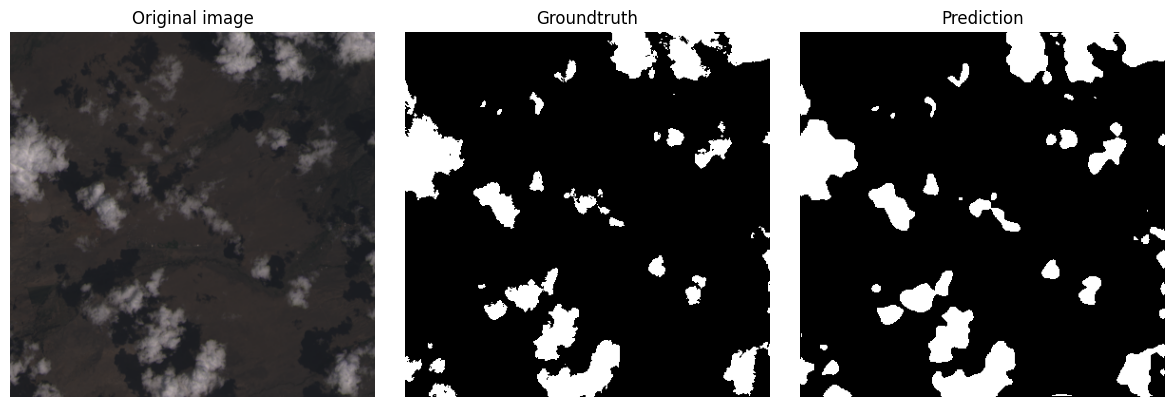

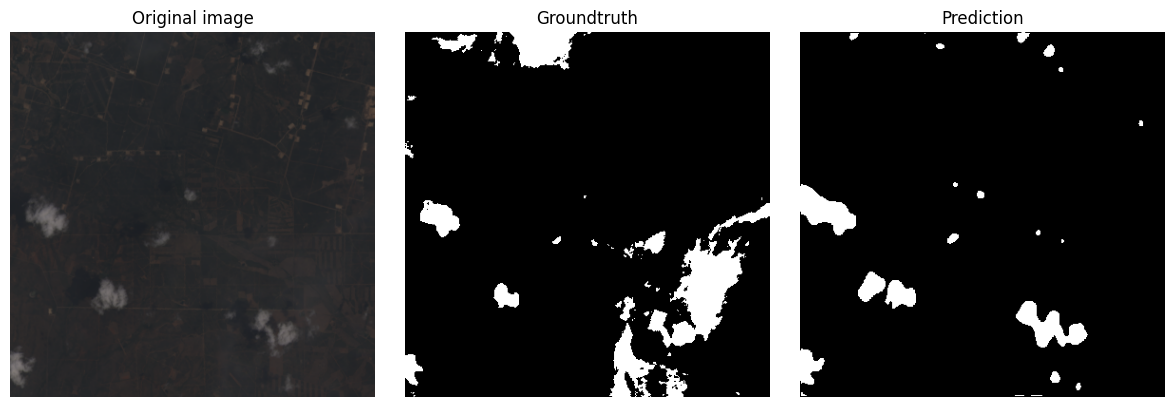

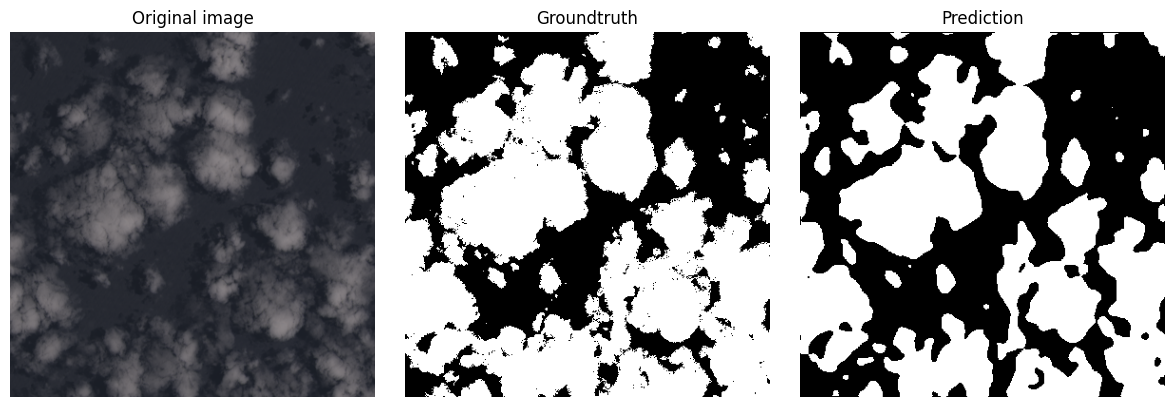

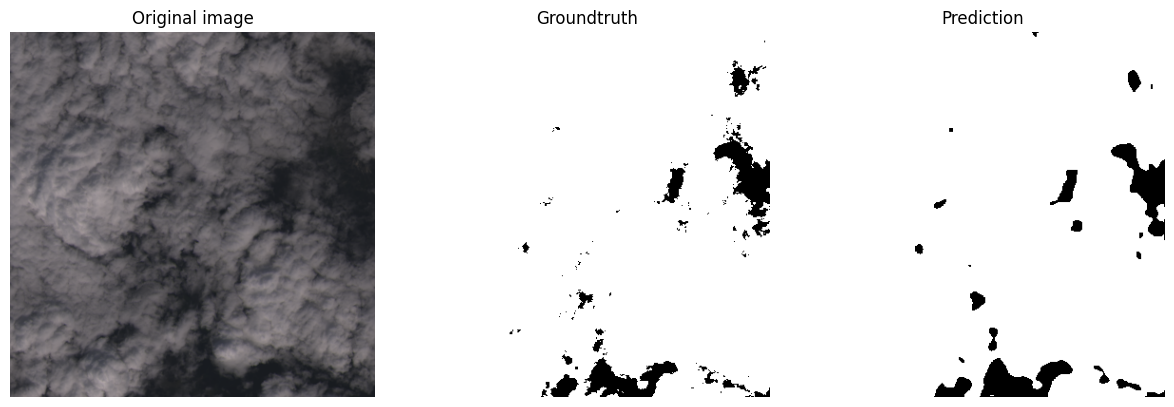

In [164]:
used_file_indices = [20, 474, 35, 98, 75, 584]
used_files = [files[i] for i in used_file_indices]

predictions = model.predict(np.array([f[0] for f in used_files]))

for f, p in zip(used_files, predictions):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    axes[0].imshow(f[0][:, :, :3])
    axes[0].set_title('Original image')
    axes[0].axis('off')
    
    axes[1].imshow(f[1], cmap='gray')
    axes[1].set_title('Groundtruth')
    axes[1].axis('off')
    
    axes[2].imshow(np.where(p < 0.5, 0, 1), cmap='gray')
    axes[2].set_title('Prediction')
    axes[2].axis('off')
    
    plt.tight_layout()
    
    plt.show()

In [32]:
class BitFlipPosition:
    RANDOM = 0
    SIGN_BIT = 1
    EXPONENT_BIT = 2
    MANTISSA_BIT = 3

In [115]:
def perform_bitflip(value: np.float32, position: int = 0) -> Tuple[np.float32, int]:
    float_bytes = struct.pack('f', value)
    bits = list(bin(int.from_bytes(float_bytes, 'little'))[2:].zfill(32))

    flip_index: int = 0
    if position == BitFlipPosition.RANDOM:
        flip_index = random.randint(0, 31)

    elif position == BitFlipPosition.SIGN_BIT:
        flip_index = 0

    elif position == BitFlipPosition.EXPONENT_BIT:
        flip_index = random.randint(1, 8)
        
    elif position == BitFlipPosition.MANTISSA_BIT:
        flip_index = random.randint(9, 31)

    else:
        raise ValueError(f'Position {position} is no part of class BitFlipPosition')

    bits[flip_index] = '1' if bits[flip_index] == '0' else '0'
    return struct.unpack('f', int(''.join(bits), 2).to_bytes(4, 'little'))[0], flip_index

In [176]:
file = open(f'results-{datetime.strftime(datetime.now(), format="%y-%m-%d-%H-%M")}.txt', 'w')
file.write('bitflip,model,layer,layerIdx,iteration,modifiedBit,valueBefore,valueAfter,file,accuracy,precision,recall,jacc\n')

for bft in tqdm([0, 1, 2, 3], desc="Fault Injection"):
    
    for weights in MODEL_WEIGHTS:
        model.load_weights(weights)
        weights_copy = copy.deepcopy(model.get_weights())
    
        # Iterate over the layers
        for i in range(len(model.trainable_variables)):
            layer_name = model.trainable_variables[i].name

            # Repeat the experiment several times
            for j in range(100):

                # Copy the weights
                iteration_weights = copy.deepcopy(weights_copy)
                
                # Weight array of layer i can either be in the shape of (X, ) or (X, X, Y, Z, )
                if len(iteration_weights[i].shape) == 1:
                    flip_idx = random.randint(0, iteration_weights[i].shape[0] - 1)
                    value_before = iteration_weights[i][flip_idx]
                    value_after, modified_bit = perform_bitflip(value_before, bft)
                    iteration_weights[i][flip_idx] = value_after
                elif len(iteration_weights[i].shape) == 4:
                    shape = iteration_weights[i].shape
                    i1, i2, i3, i4 = (random.randint(0, shape[k] - 1) for k in range(4))
                    value_before = iteration_weights[i][i1, i2, i3, i4]
                    value_after, modified_bit = perform_bitflip(value_before, bft)
                    iteration_weights[i][i1, i2, i3, i4] = value_after
                else:
                    raise ValueError(f'Unexpected shape of the model found: {iteration_weights[i].shape}')

                model.set_weights(iteration_weights)

                counter = 0
                imgs = np.array([x[0] for x in used_files[2:4]])
                msks = np.array([x[1] for x in used_files[2:4]])

                result = model.predict(imgs)

                for r, m in zip(result, msks):
                    accuracy_val = overall_accuracy(m, r[:, :, 0])
                    precision_val = precision(m, r[:, :, 0])
                    recall_val = recall(m, r[:, :, 0])
                    jacc_val = jacc_coef(m, r[:, :, 0])

                    file.write(f'{bft},{weights},{layer_name},{i},{j},{modified_bit},{value_before},{value_after},{counter},{accuracy_val},{precision_val},{recall_val},{jacc_val}\n')
                    counter += 1
file.close()
print("[!] Done")

Fault Injection: 100%|██████████████████████████████████████████████████████████| 4/4 [32:04<00:00, 481.18s/it]

[!] Done


In [180]:
iteration_weights = copy.deepcopy(weights_copy)
model.set_weights(iteration_weights)

imgs = np.array([f[0] for f in used_files[2:4]])
msks = np.array([f[1] for f in used_files[2:4]])

predictions = model.predict(imgs)

counter = 1
for r, m in zip(predictions, msks):
    accuracy_val = overall_accuracy(m, r[:, :, 0])
    precision_val = precision(m, r[:, :, 0])
    recall_val = recall(m, r[:, :, 0])
    jacc_val = jacc_coef(m, r[:, :, 0])

    print(f"-----------------------------")
    print(f"[I] Image {counter}")
    print(f"[I] Accuracy:  {accuracy_val}")
    print(f"[I] Precision: {precision_val}")
    print(f"[I] Recall:    {recall_val}")
    print(f"[I] Jacc val:  {jacc_val}")

    counter += 1

-----------------------------
[I] Image 1
[I] Accuracy:  0.9596489667892456
[I] Precision: 0.8204136490821838
[I] Recall:    0.9031779170036316
[I] Jacc val:  0.33387452363967896
-----------------------------
[I] Image 2
[I] Accuracy:  0.9096747636795044
[I] Precision: 0.4763926565647125
[I] Recall:    0.21509087085723877
[I] Jacc val:  0.8217544555664062
